In [2]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

from nltk.corpus import stopwords
from nltk.util import ngrams

from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import classification_report,confusion_matrix

from collections import defaultdict
from collections import Counter
plt.style.use('ggplot')
stop=set(stopwords.words('english'))

import re
from nltk.tokenize import word_tokenize
import gensim
import string

from tqdm import tqdm
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM,Dense, SpatialDropout1D, Dropout
from keras.initializers import Constant
from keras.optimizers import Adam

import torch

import warnings
warnings.simplefilter('ignore')

In [4]:
tweet= pd.read_csv('/content/train.csv')
test=pd.read_csv('/content/test.csv')

In [5]:
print('There are {} rows and {} columns in train'.format(tweet.shape[0],tweet.shape[1]))
print('There are {} rows and {} columns in train'.format(test.shape[0],test.shape[1]))

There are 7613 rows and 5 columns in train
There are 3263 rows and 4 columns in train


In [6]:
tweet.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [7]:
Real = tweet[tweet['target'] == 1].shape[0]
NotR = tweet[tweet['target'] == 0].shape[0]

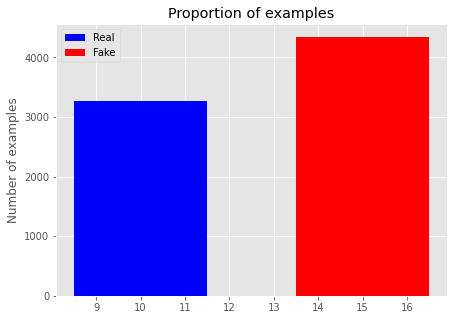

In [9]:
plt.rcParams['figure.figsize'] = (7, 5)
plt.bar(10,Real,3, label="Real", color='blue')
plt.bar(15,NotR,3, label="Fake", color='red')
plt.legend()
plt.ylabel('Number of examples')
plt.title('Proportion of examples')
plt.show()

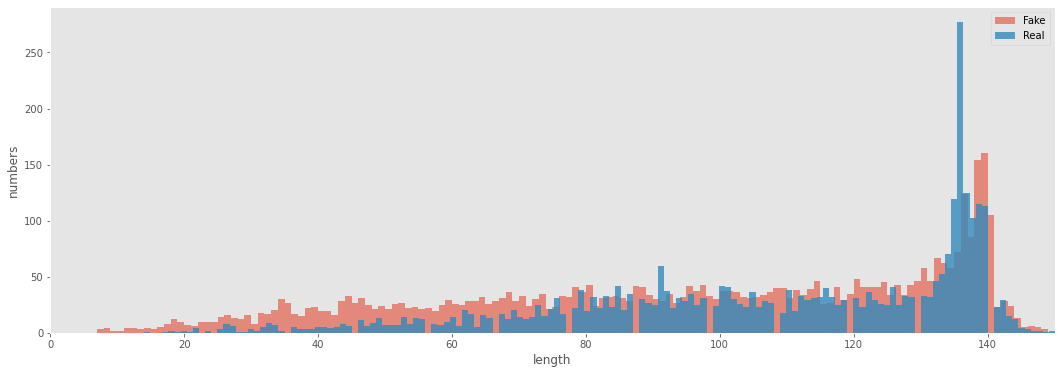

In [10]:
def length(text):    
    return len(text)

tweet['length'] = tweet['text'].apply(length)

plt.rcParams['figure.figsize'] = (18.0, 6.0)
bins = 150
plt.hist(tweet[tweet['target'] == 0]['length'], alpha = 0.6, bins=bins, label='Fake')
plt.hist(tweet[tweet['target'] == 1]['length'], alpha = 0.8, bins=bins, label='Real')
plt.xlabel('length')
plt.ylabel('numbers')
plt.legend(loc='upper right')
plt.xlim(0,150)
plt.grid()
plt.show()


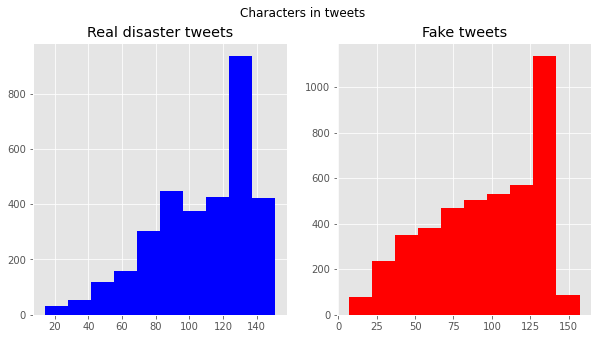

In [11]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=tweet[tweet['target']==1]['text'].str.len()
ax1.hist(tweet_len,color='blue')
ax1.set_title('Real disaster tweets')
tweet_len=tweet[tweet['target']==0]['text'].str.len()
ax2.hist(tweet_len,color='red')
ax2.set_title('Fake tweets')
fig.suptitle('Characters in tweets')
plt.show()

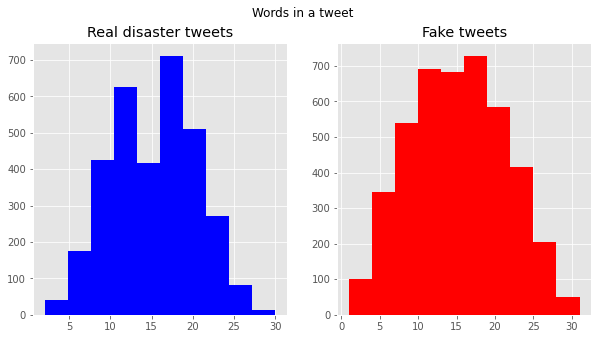

In [12]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=tweet[tweet['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len,color='blue')
ax1.set_title('Real disaster tweets')
tweet_len=tweet[tweet['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len,color='red')
ax2.set_title('Fake tweets')
fig.suptitle('Words in a tweet')
plt.show()

Text(0.5, 0.98, 'Average word length in each tweet')

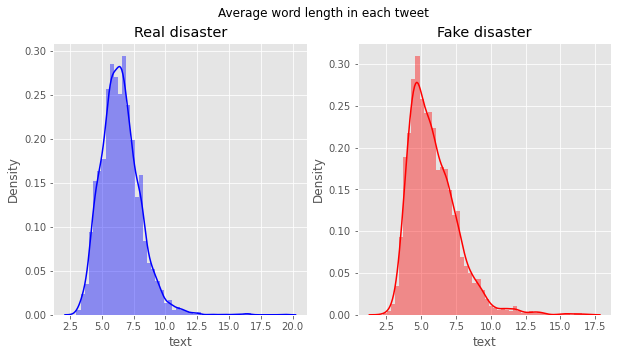

In [13]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
word=tweet[tweet['target']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='blue')
ax1.set_title('Real disaster')
word=tweet[tweet['target']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='red')
ax2.set_title('Fake disaster')
fig.suptitle('Average word length in each tweet')

In [14]:
def create_corpus(target):
    corpus=[]
    
    for x in tweet[tweet['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

def create_corpus_df(tweet, target):
    corpus=[]
    
    for x in tweet[tweet['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

<BarContainer object of 10 artists>

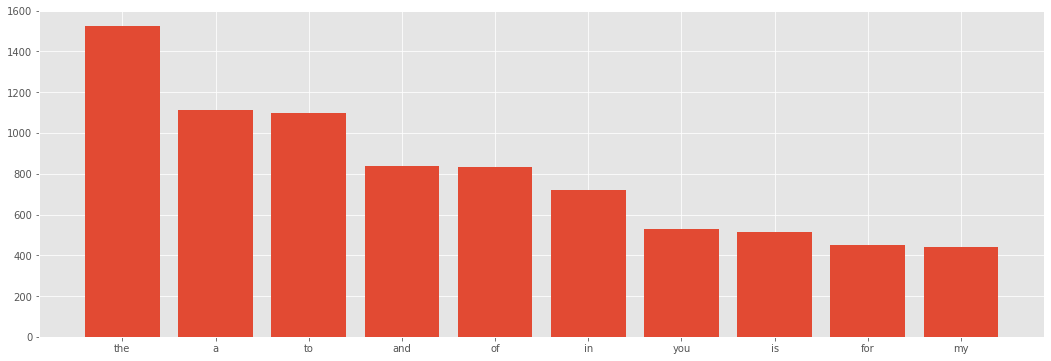

In [15]:
corpus=create_corpus(0)

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10]


plt.rcParams['figure.figsize'] = (18.0, 6.0)
x,y=zip(*top)
plt.bar(x,y)

<BarContainer object of 10 artists>

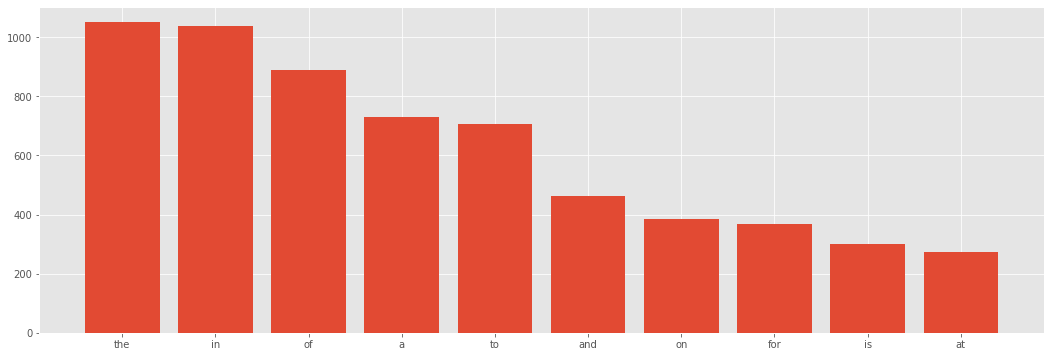

In [16]:
corpus=create_corpus(1)

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1

top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
    

plt.rcParams['figure.figsize'] = (18.0, 6.0)
x,y=zip(*top)
plt.bar(x,y)

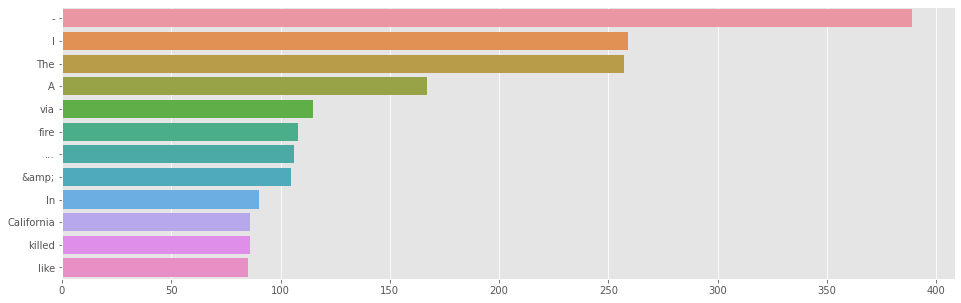

In [17]:
plt.figure(figsize=(16,5))
counter=Counter(corpus)
most=counter.most_common()
x=[]
y=[]
for word,count in most[:40]:
    if (word not in stop) :
        x.append(word)
        y.append(count)

sns.barplot(x=y,y=x)

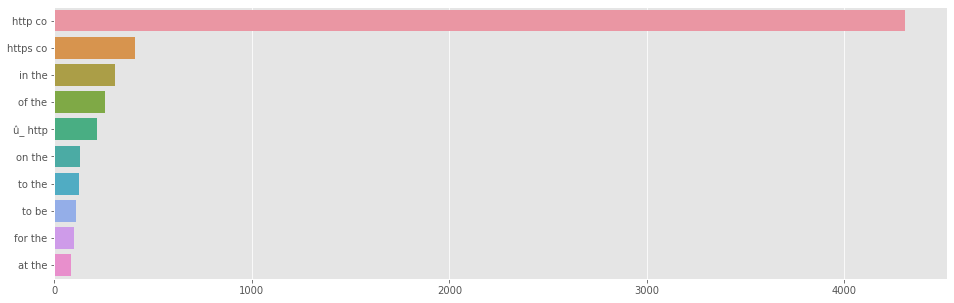

In [18]:
def get_top_tweet_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

plt.figure(figsize=(16,5))
top_tweet_bigrams=get_top_tweet_bigrams(tweet['text'])[:10]
x,y=map(list,zip(*top_tweet_bigrams))
sns.barplot(x=y,y=x)

In [19]:
#Data Cleaning

df=pd.concat([tweet,test])
df.shape

(10876, 6)

In [20]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

df['text']=df['text'].apply(lambda x : remove_URL(x))

In [21]:
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

df['text']=df['text'].apply(lambda x : remove_html(x))

In [22]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

df['text']=df['text'].apply(lambda x: remove_emoji(x))

In [23]:
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

df['text']=df['text'].apply(lambda x : remove_punct(x))

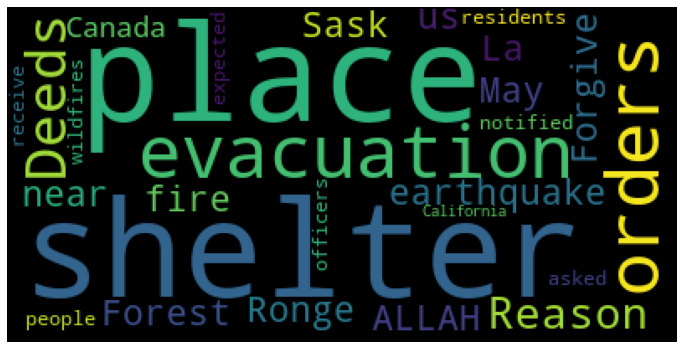

In [24]:
#WordCloud
#Real
corpus_new1=create_corpus_df(df,1)
plt.figure(figsize=(12,8))
word_cloud = WordCloud(background_color='black', max_font_size = 80).generate(" ".join(corpus_new1[:50]))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

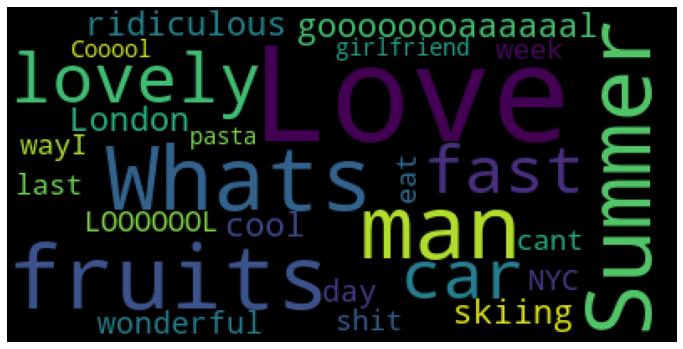

In [25]:
#Fake WordCloud

corpus_new0=create_corpus_df(df,0)
plt.figure(figsize=(12,8))
word_cloud = WordCloud(
                          background_color='black',
                          max_font_size = 80
                         ).generate(" ".join(corpus_new0[:50]))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

In [26]:
df.head(10)

,id,keyword,location,text,target,length
0,1,NaN,NaN,Our Deeds are the Reason of this earthquake Ma...,1.0,69.0
1,4,NaN,NaN,Forest fire near La Ronge Sask Canada,1.0,38.0
2,5,NaN,NaN,All residents asked to shelter in place are be...,1.0,133.0
3,6,NaN,NaN,13000 people receive wildfires evacuation orde...,1.0,65.0
4,7,NaN,NaN,Just got sent this photo from Ruby Alaska as s...,1.0,88.0
5,8,NaN,NaN,RockyFire Update California Hwy 20 closed in ...,1.0,110.0
6,10,NaN,NaN,flood disaster Heavy rain causes flash floodin...,1.0,95.0
7,13,NaN,NaN,Im on top of the hill and I can see a fire in ...,1.0,59.0
8,14,NaN,NaN,Theres an emergency evacuation happening now i...,1.0,79.0
9,15,NaN,NaN,Im afraid that the tornado is coming to our area,1.0,52.0


In [27]:
#Bag Of Words

def cv(data):
    count_vectorizer = CountVectorizer()

    emb = count_vectorizer.fit_transform(data)

    return emb, count_vectorizer

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

list_corpus = df["text"].tolist()
list_labels = df["target"].tolist()

X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2,random_state=40)

X_train_counts, count_vectorizer = cv(X_train)
X_test_counts = count_vectorizer.transform(X_test)

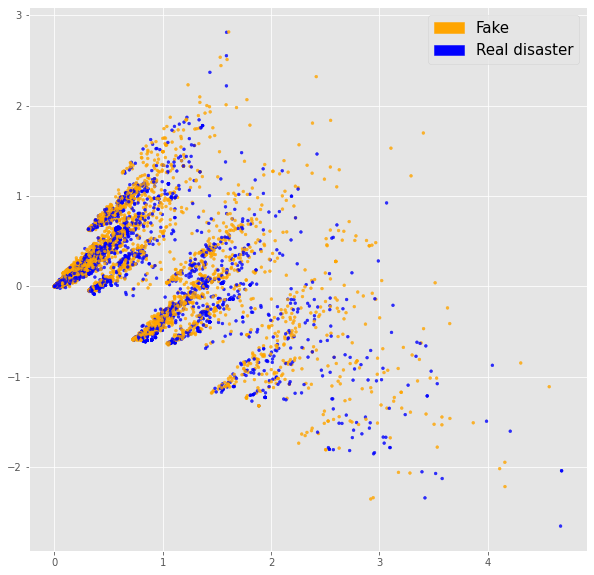

In [29]:
def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','blue']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            orange_patch = mpatches.Patch(color='orange', label='Fake')
            blue_patch = mpatches.Patch(color='blue', label='Real disaster')
            plt.legend(handles=[orange_patch, blue_patch], prop={'size': 15})

fig = plt.figure(figsize=(10, 10))          
plot_LSA(X_train_counts, y_train)
plt.show()

In [30]:
#TFIDF

def tfidf(data):
    tfidf_vectorizer = TfidfVectorizer()

    train = tfidf_vectorizer.fit_transform(data)

    return train, tfidf_vectorizer

X_train_tfidf, tfidf_vectorizer = tfidf(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

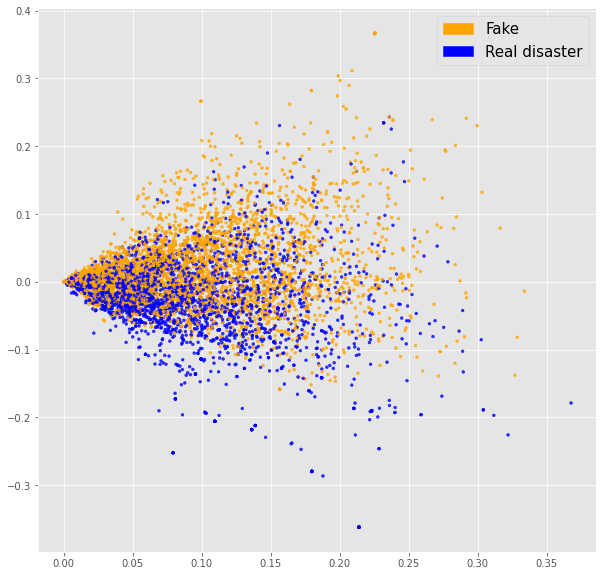

In [31]:
fig = plt.figure(figsize=(10, 10))          
plot_LSA(X_train_tfidf, y_train)
plt.show()

In [ ]:
#GloVe

def create_corpus_new(df):
    corpus=[]
    for tweet in tqdm(df['text']):
        words=[word.lower() for word in word_tokenize(tweet)]
        corpus.append(words)
    return corpus   

In [ ]:
import nltk
nltk.download('punkt')
corpus=create_corpus_new(df)

  8%|▊         | 818/10876 [00:00<00:01, 8175.47it/s]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


100%|██████████| 10876/10876 [00:01<00:00, 7756.88it/s]


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
embedding_dict={}
with open('gdrive/My Drive/glove.6B.100d.txt','r') as f:
    for line in f:
        values=line.split()
        word = values[0]
        vectors=np.asarray(values[1:],'float32')
        embedding_dict[word]=vectors
f.close()

In [ ]:
MAX_LEN=50
tokenizer_obj=Tokenizer()
tokenizer_obj.fit_on_texts(corpus)
sequences=tokenizer_obj.texts_to_sequences(corpus)

tweet_pad=pad_sequences(sequences,maxlen=MAX_LEN,truncating='post',padding='post')

In [ ]:
word_index=tokenizer_obj.word_index
print('Number of unique words:',len(word_index))

Number of unique words: 22807


In [ ]:
num_words=len(word_index)+1
embedding_matrix=np.zeros((num_words,100))

for word,i in tqdm(word_index.items()):
    if i < num_words:
        emb_vec=embedding_dict.get(word)
        if emb_vec is not None:
            embedding_matrix[i]=emb_vec

100%|██████████| 22807/22807 [00:00<00:00, 585094.81it/s]


In [ ]:
tweet_pad[0][0:]

array([ 100, 5778,   20,    1,  814,    5,   18,  237,  136, 1902, 3703,
         68,   39,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0], dtype=int32)

In [ ]:
model=Sequential()

embedding=Embedding(num_words,100,embeddings_initializer=Constant(embedding_matrix),
                   input_length=MAX_LEN,trainable=False)

model.add(embedding)
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0))
model.add(Dense(1, activation='sigmoid'))


optimzer=Adam(learning_rate=3e-4)

model.compile(loss='binary_crossentropy',optimizer=optimzer,metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 50, 100)           2280800   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 50, 100)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 2,361,301
Trainable params: 80,501
Non-trainable params: 2,280,800
_________________________________________________________________


In [ ]:
train=tweet_pad[:tweet.shape[0]]
test=tweet_pad[tweet.shape[0]:]

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(train,tweet['target'].values,test_size=0.2)
print('Shape of train',X_train.shape)
print("Shape of Validation ",X_test.shape)

Shape of train (6090, 50)
Shape of Validation  (1523, 50)


In [ ]:
history=model.fit(X_train,y_train,batch_size=4,epochs=10,validation_data=(X_test,y_test),verbose=2)

Epoch 1/10
1523/1523 - 8s - loss: 0.5267 - accuracy: 0.7552 - val_loss: 0.4518 - val_accuracy: 0.8011
Epoch 2/10
1523/1523 - 8s - loss: 0.4862 - accuracy: 0.7829 - val_loss: 0.4302 - val_accuracy: 0.8181
Epoch 3/10
1523/1523 - 8s - loss: 0.4757 - accuracy: 0.7823 - val_loss: 0.4322 - val_accuracy: 0.8175
Epoch 4/10
1523/1523 - 8s - loss: 0.4741 - accuracy: 0.7852 - val_loss: 0.4356 - val_accuracy: 0.8116
Epoch 5/10
1523/1523 - 8s - loss: 0.4641 - accuracy: 0.7926 - val_loss: 0.4361 - val_accuracy: 0.8142
Epoch 6/10
1523/1523 - 8s - loss: 0.4536 - accuracy: 0.7979 - val_loss: 0.4299 - val_accuracy: 0.8109
Epoch 7/10
1523/1523 - 8s - loss: 0.4511 - accuracy: 0.7964 - val_loss: 0.4254 - val_accuracy: 0.8253
Epoch 8/10
1523/1523 - 9s - loss: 0.4440 - accuracy: 0.8021 - val_loss: 0.4267 - val_accuracy: 0.8273
Epoch 9/10
1523/1523 - 8s - loss: 0.4396 - accuracy: 0.8046 - val_loss: 0.4139 - val_accuracy: 0.8221
Epoch 10/10
1523/1523 - 8s - loss: 0.4292 - accuracy: 0.8125 - val_loss: 0.4163 - 

In [ ]:
def plot_learning_curves(history): 
    fig, ax = plt.subplots(1, 2, figsize = (20, 10))

    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])

    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])

    ax[0].legend(['train', 'validation'], loc = 'upper left')
    ax[1].legend(['train', 'validation'], loc = 'upper left')

    fig.suptitle("Model Accuracy", fontsize=14)

    ax[0].set_ylabel('Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    ax[1].set_xlabel('Epoch')

    return plt.show()

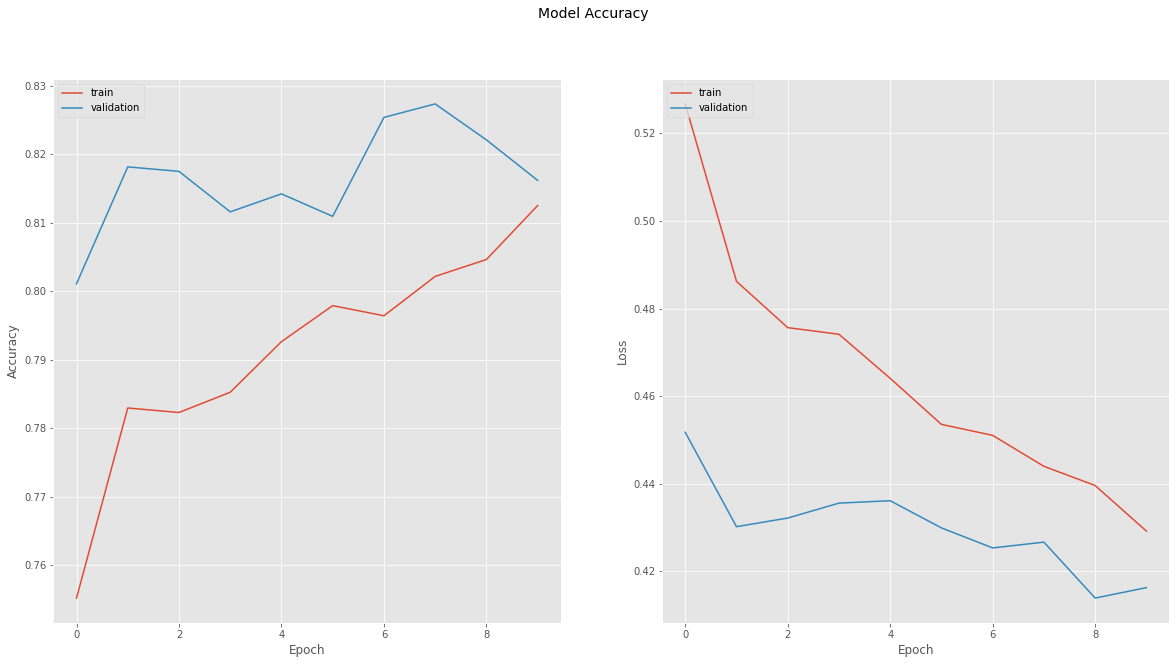

In [ ]:
plot_learning_curves(history)

In [ ]:
train_pred_GloVe = model.predict(train)
train_pred_GloVe_int = train_pred_GloVe.round().astype('int')

In [ ]:
train_pred_GloVe_int

array([[0],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]])

In [ ]:
def plot_cm(y_true, y_pred, title, figsize=(5,5)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    plt.title(title)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)

In [ ]:
trainn= pd.read_csv('/content/train.csv')

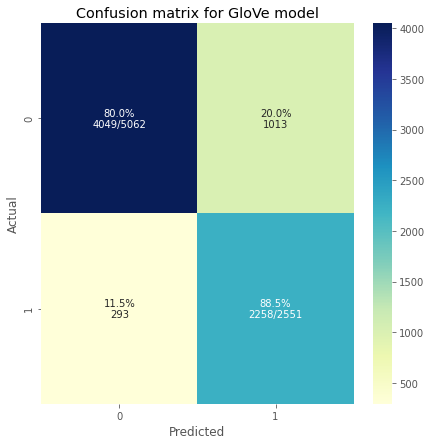

In [ ]:
plot_cm(train_pred_GloVe_int, trainn['target'].values, 
        'Confusion matrix for GloVe model', figsize=(7,7))